# KCHOL HİSSE SENEDİ

Bu çalışmada **KCHOL** hisse senedinin "2021-01-01", "2024-01-01" tarihleri arasındaki kapanış fiyatlarının farklı makine öğrenimi modelleriyle tahminleri yapılacak, bu tahminler üzerinden iyileştirmeler yapılarak analiz yapılacaktır.

In [1]:
# Veri okuma ve işleme adımında kullanılacak kütüphaneler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# !pip install tensorflow
import tensorflow as tf

# Model için kullanılacak kütüphaneler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model değerlendirme ve veri ölçeklendirmede kullanılacak kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Uyarıları kapatmak için kullanılacak kütüphaneler
import itertools
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
#import yfinance as yf
#df = yf.download("KCHOL.IS", start="2021-01-01", end="2024-01-01");

In [3]:
df = pd.read_csv("KCHOL.IS.csv")

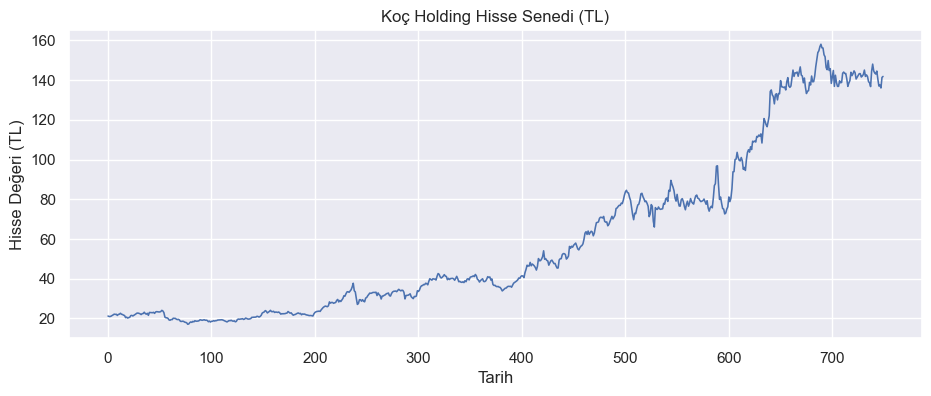

In [4]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = df["Close"].plot(linestyle='-', linewidth=1.15, label='Daily')
ax.set_ylabel("Hisse Değeri (TL)")
ax.set_xlabel("Tarih")
ax.set_title("Koç Holding Hisse Senedi (TL)")
plt.show();

In [5]:
# Eğitim-Doğrulama-Test seti olarak bölelim:   85-7.5-7.5
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)

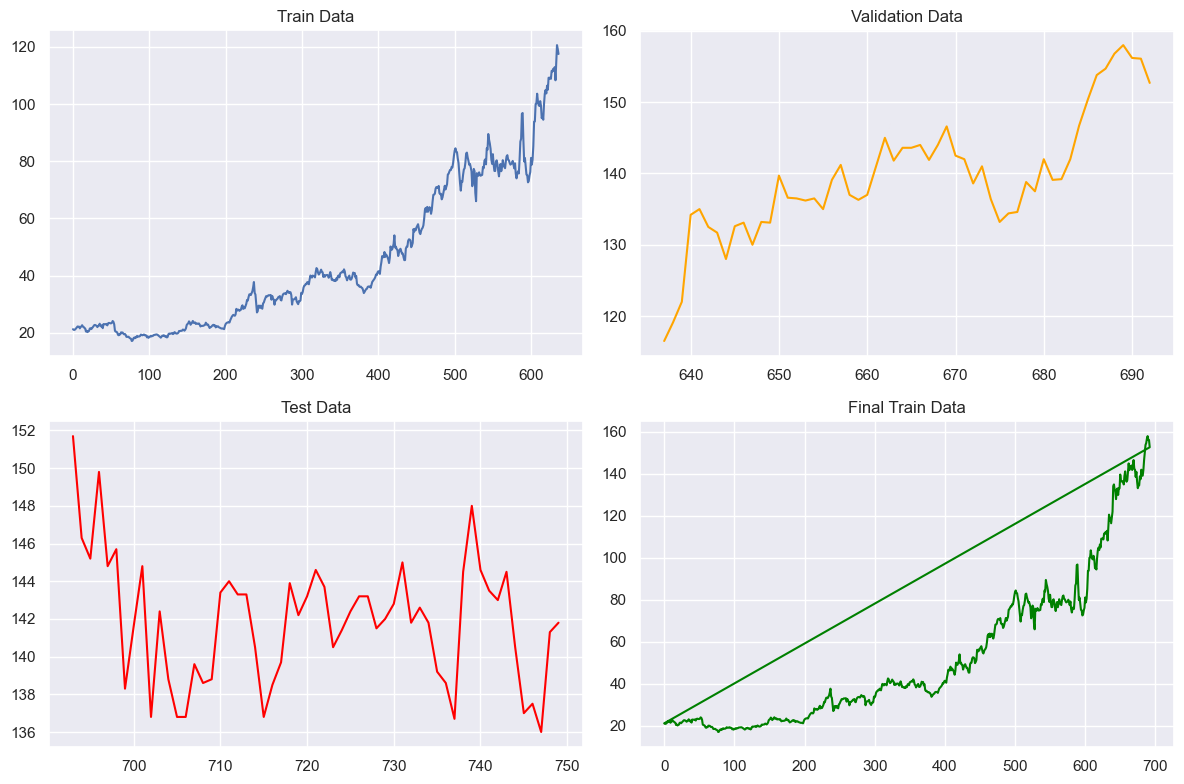

In [6]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
train.plot(ax=axes[0, 0], title="Train Data")
validation.plot(ax=axes[0, 1], title="Validation Data",color="orange")
test.plot(ax=axes[1, 0], title="Test Data",color="red")
final_train.plot(ax=axes[1, 1], title="Final Train Data",color="green")
plt.tight_layout()
plt.show();

# SES MODEL 

## SES MODEL PARAMETRE OPTİMİZASYONU

In [57]:
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
len(train), len(validation), len(test)
def ses_optimizer(train, alphas, step=len(validation)):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        validation_pred = ses_model.forecast(step)
        mae = mean_absolute_error(validation, validation_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae
alphas = np.arange(0.01, 1, 0.01)
best_alpha, best_mae = ses_optimizer(train, alphas, step=len(validation)) # best_alpha: 0.67 best_mae: 21.5837

best_alpha: 0.67 best_mae: 21.5837


### ONE STEP AHEAD METHOD(SES)

In [58]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
kchol_ses_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = SimpleExpSmoothing(final_train).fit(smoothing_level=best_alpha)
    output = model_fit.forecast()
    yhat = output[0]
    kchol_ses_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### SES MODEL HATASI

In [65]:
kchol_ses_rmse = np.sqrt(mean_squared_error(test,kchol_ses_model_predictions)) # RMSE = 5.363891816472977
test = np.array(test)
kchol_ses_model_predictions = np.array(kchol_ses_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
kchol_ses_mape = mape(test,kchol_ses_model_predictions) # MAPE =  1.9538717684636504
print("RMSE =",kchol_ses_rmse),print("MAPE =",kchol_ses_mape);

RMSE = 5.363891816472977
MAPE = 1.9538717684636504


### SES MODELİNİN TAHMİN GRAFİĞİ:

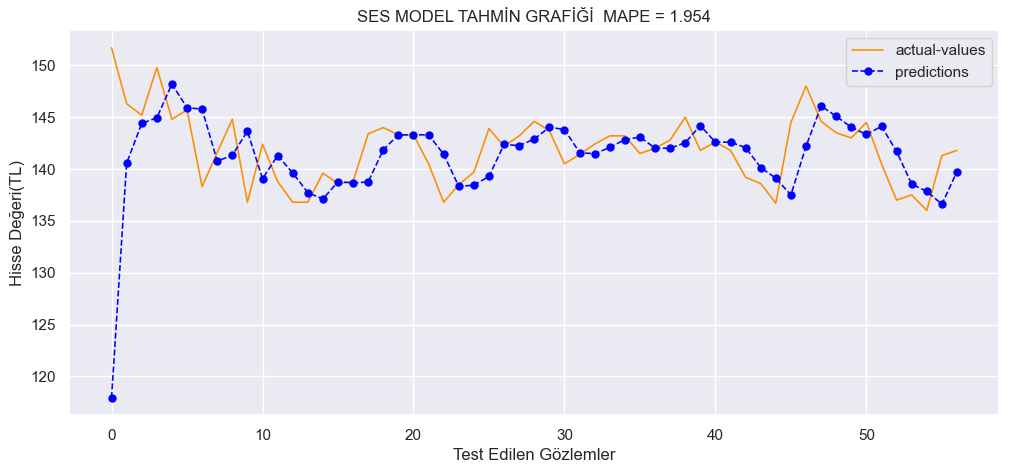

In [61]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(kchol_ses_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Test Edilen Gözlemler")
plt.ylabel("Hisse Değeri(TL)")
plt.title("SES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(kchol_ses_mape,3)))
plt.legend();

SES MODEL tahminleri mavi, gerçek değerler sarı renkli belirtilmiştir.  

# DES MODEL

## DES MODEL PARAMETRE OPTİMİZASYONU

In [62]:
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
def des_optimizer(train, alphas, betas, step=len(validation)):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            validation_pred = des_model.forecast(step)
            mae = mean_absolute_error(validation, validation_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae
alphas = np.arange(0.01, 1, 0.01)
betas = np.arange(0.1, 1, 0.01)
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=len(validation))
# best_alpha: 0.02 best_beta: 0.61 best_mae: 4.4694

best_alpha: 0.02 best_beta: 0.61 best_mae: 4.4694


### ONE STEP AHEAD METHOD(DES)

In [63]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
kchol_des_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = ExponentialSmoothing(final_train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
    output = model_fit.forecast()
    yhat = output[0]
    kchol_des_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

In [13]:
#test = np.delete(test,0)
#kchol_des_model_predictions = np.delete(kchol_des_model_predictions,0)

### DES MODEL HATASI

In [69]:
kchol_des_rmse = np.sqrt(mean_squared_error(test,kchol_des_model_predictions)) # RMSE = 10.320334750984863
test = np.array(test)
kchol_des_model_predictions = np.array(kchol_des_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
kchol_des_mape = mape(test,kchol_des_model_predictions) # MAPE = 6.492775123607776
print("RMSE =",kchol_des_rmse), print("MAPE =",kchol_des_mape);

RMSE = 10.834769705597562
MAPE = 6.492775123607776


### DES MODEL TAHMİN GRAFİĞİ:

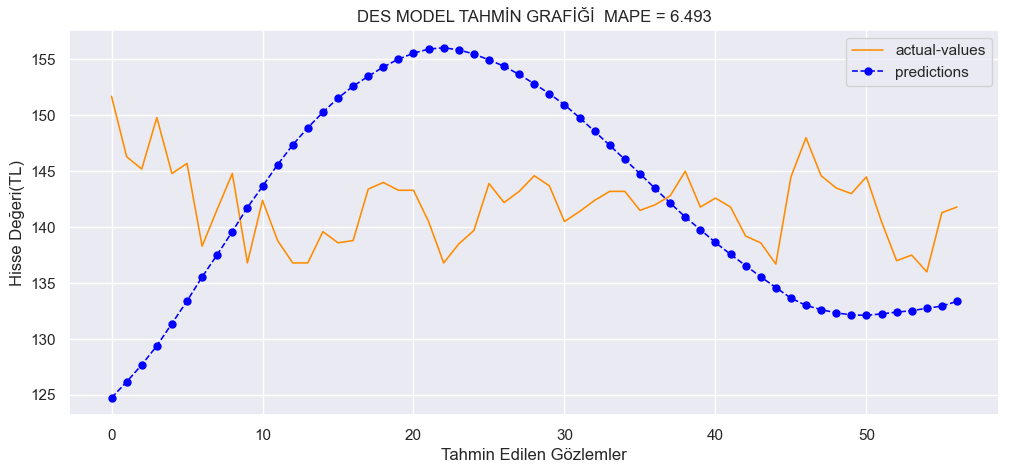

In [70]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(kchol_des_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tahmin Edilen Gözlemler")
plt.ylabel("Hisse Değeri(TL)")
plt.title("DES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(kchol_des_mape,3)))
plt.legend();

# TES MODEL

## TES MODEL PARAMETRE OPTİMİZASYONU

In [71]:
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
def tes_optimizer(train, abg, step=len(validation)):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        validation_pred = tes_model.forecast(step)
        mae = mean_absolute_error(validation, validation_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae
alphas = betas = gammas = np.arange(0.01, 1, 0.1)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=len(validation))
# best_alpha: 0.51 best_beta: 0.91 best_gamma: 0.01 best_mae: 5.5149

best_alpha: 0.51 best_beta: 0.91 best_gamma: 0.01 best_mae: 5.5149


### ONE STEP AHEAD METHOD

In [72]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
kchol_tes_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = ExponentialSmoothing(final_train, trend="add", seasonal="add", seasonal_periods=5).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
    # model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    kchol_tes_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

In [18]:
#test = np.delete(test,0)
#kchol_tes_model_predictions = np.delete(kchol_tes_model_predictions,0)

### TES MODEL HATASI

In [74]:
kchol_tes_rmse = np.sqrt(mean_squared_error(test,kchol_tes_model_predictions)) # RMSE = RMSE = 6.123849282852851
test = np.array(test)
kchol_tes_model_predictions = np.array(kchol_tes_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
kchol_tes_mape = mape(test,kchol_tes_model_predictions) # MAPE = 2.752109793937778
print("RMSE =",kchol_tes_rmse), print("MAPE =",kchol_tes_mape);

RMSE = 6.123849282852851
MAPE = 2.752109793937778


### TES MODEL TAHMİN GRAFİĞİ:

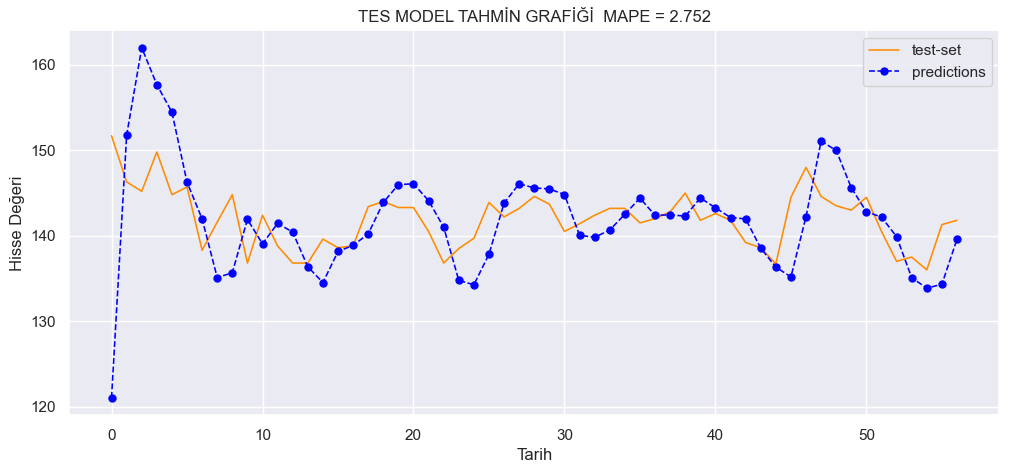

In [75]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(kchol_tes_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("TES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(kchol_tes_mape,3)))
plt.legend();

# ARIMA MODEL
## ARIMA MODEL PARAMETRE OPTİMİZASYONU

In [76]:
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model = sm.tsa.ARIMA(train, order=order).fit()
            aic = arima_model.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params
best_params_aic = arima_optimizer_aic(train, pdq)
# Best ARIMA(2, 1, 2) AIC=2412.22  <- parametreler.

Best ARIMA(2, 1, 2) AIC=2412.22


### ONE STEP AHEAD METHOD

In [77]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
kchol_arima_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model = sm.tsa.ARIMA(final_train, order=best_params_aic)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    kchol_arima_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

In [23]:
#test = np.delete(test,0)
#kchol_arima_model_predictions = np.delete(kchol_arima_model_predictions,0)

### ARIMA MODEL HATASI

In [78]:
kchol_arima_rmse = np.sqrt(mean_squared_error(test,kchol_arima_model_predictions)) # RMSE = 5.492907260660071
test = np.array(test)
kchol_arima_model_predictions = np.array(kchol_arima_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
kchol_arima_mape = mape(test,kchol_arima_model_predictions) # MAPE = 2.047729711253067
print("RMSE =",kchol_arima_rmse), print("MAPE =",kchol_arima_mape);

RMSE = 5.492907260660071
MAPE = 2.047729711253067


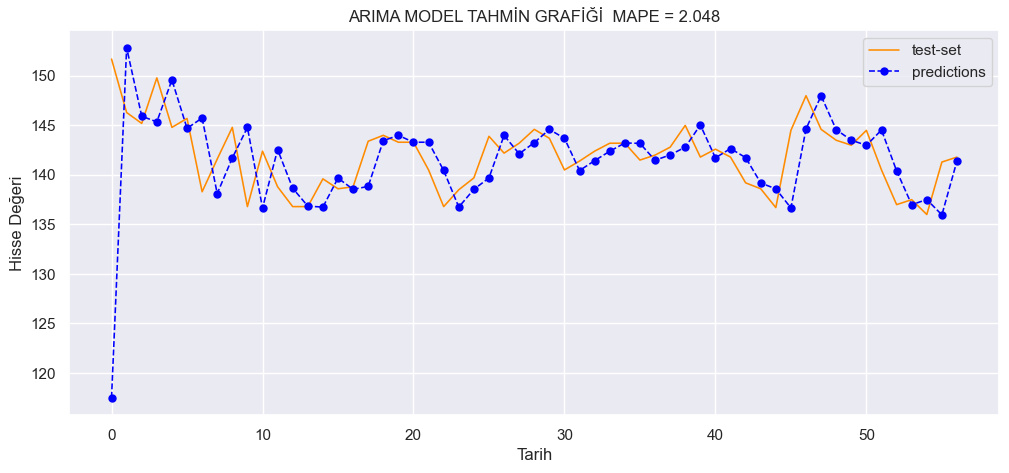

In [79]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(kchol_arima_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("ARIMA MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(kchol_arima_mape,3)))
plt.legend();

# SARIMA MODEL
## SARIMA MODEL PARAMETRE OPTİMİZASYONU

In [80]:
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p, d, q))]
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)
# SARIMA(0, 1, 1)x(1, 1, 1, 5)12 - AIC:2418.6327397765854 <- parametreler.

SARIMA(0, 1, 1)x(1, 1, 1, 5)12 - AIC:2418.632725501306


### ONE STEP AHEAD METHOD

In [81]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
kchol_sarima_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model = SARIMAX(final_train, order=best_order, seasonal_order=best_seasonal_order)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    kchol_sarima_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

In [28]:
#test = np.delete(test,0)
#kchol_sarima_model_predictions = np.delete(kchol_sarima_model_predictions,0)

### SARIMA MODEL HATASI

In [82]:
kchol_sarima_rmse = np.sqrt(mean_squared_error(test,kchol_sarima_model_predictions)) # RMSE = 5.473527362193324
test = np.array(test)
kchol_sarima_model_predictions = np.array(kchol_sarima_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
kchol_sarima_mape = mape(test,kchol_sarima_model_predictions) # MAPE = 2.051535694528855
print("RMSE =",kchol_sarima_rmse), print("MAPE =",kchol_sarima_mape);

RMSE = 5.473527362193324
MAPE = 2.051535694528855


### SARIMA MODEL TAHMİN GRAFİĞİ

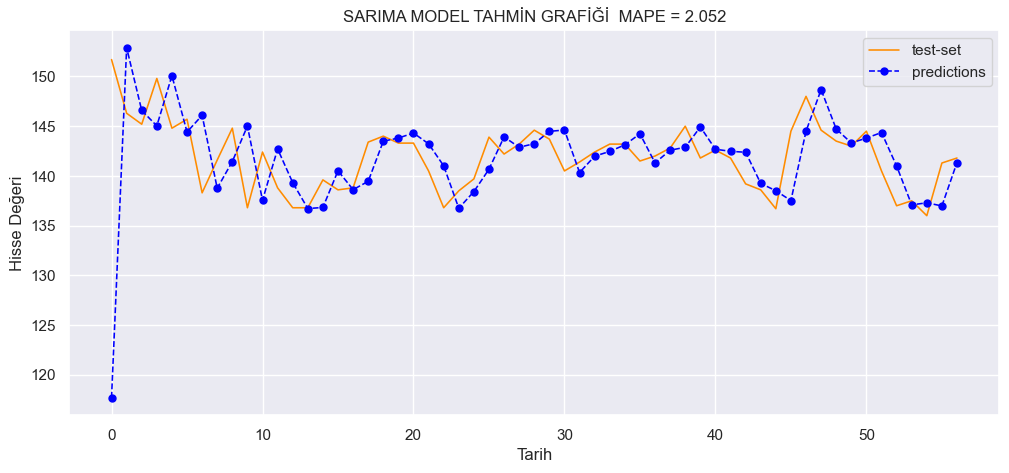

In [83]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(kchol_sarima_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("SARIMA MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(kchol_sarima_mape,3)))
plt.legend();

# ANN MODEL(LSTM)

In [84]:
data = pd.read_csv("KCHOL.IS.csv")
prices = data['Close'].values

### Veri Ölçeklendirme

In [85]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

### ONE STEP AHEAD METHOD DATA CREATION

In [86]:
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)
lookback = 10

### Veri Bölümlemesi

In [87]:
train_size = int(len(prices_scaled) * 0.925) 
train_data = prices_scaled[:train_size]
test_data = prices_scaled[train_size - lookback:]  
train_size, len(train_data), len(test_data)

(693, 693, 67)

In [88]:
# Ayrı ayrı veri seti oluştur
X_train, y_train = create_dataset(train_data, lookback)
X_test, y_test = create_dataset(test_data, lookback)
# LSTM için giriş verisini yeniden şekillendir
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [89]:
# Model oluştur
tf.random.set_seed(42)
model = Sequential([
    LSTM(50, activation='relu', input_shape=(lookback, 1)),
    Dense(1)])
# Modeli derle
model.compile(optimizer='adam', loss='mse')
# Modeli eğit
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0600 - val_loss: 0.0023
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0120
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0119e-04 - val_loss: 0.0025
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3418e-04 - val_loss: 0.0022
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2132e-04 - val_loss: 0.0018
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0131e-04 - val_loss: 0.0017
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9162e-04 - val_loss: 0.0015
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8172e-04 - val_loss: 0.0014
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7241e-04 - val_loss: 0.0013
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6336e-04 - val_loss: 0.0012
Epoch 12/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 

### ANN MODEL HATASI

In [90]:
kchol_ann_pred = model.predict(X_test)
# Veriyi orijinal ölçeğe geri çevir
y_pred_ann_inverse = scaler.inverse_transform(kchol_ann_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
def mape(actual, predictions):
    return np.mean(np.abs((actual - predictions) / actual)) * 100
kchol_ann_mape = mape(y_test_inverse, y_pred_ann_inverse)
print(kchol_ann_mape) # MAPE = 1.8985168772775964

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x308749440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1.8985168772775964


In [91]:
test = np.array(y_test_inverse)
kchol_ann_model_predictions = np.array(y_pred_ann_inverse)

In [114]:
kchol_ann_rmse = np.sqrt(mean_squared_error(test,kchol_ann_model_predictions)) # RMSE = 3.425057027257531
print(kchol_ann_rmse);

3.425057027257531


### ANN MODEL TAHMİN GRAFİĞİ

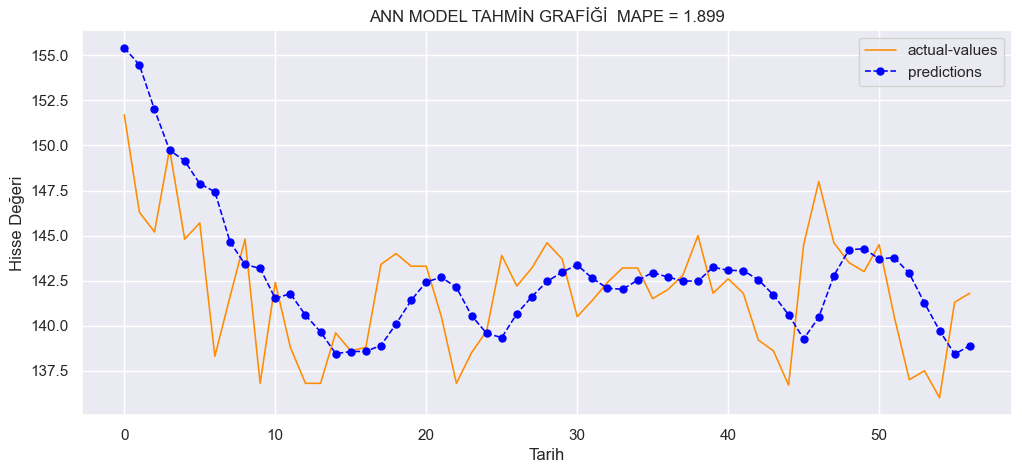

In [92]:
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(kchol_ann_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("ANN MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(kchol_ann_mape,3)))
plt.legend();

# CNN MODEL


In [93]:
from tensorflow.keras.layers import Conv1D, Dense, Flatten

In [94]:
data = pd.read_csv("KCHOL.IS.csv")
prices = data["Close"].values

In [96]:
len(validation),len(test)

(56, 57)

In [95]:
# Parametreler
lookback = 10
test_size = 57
# Veriyi böl (lookback'i unutma!)
train_prices = prices[:-(test_size)]
test_prices = prices[-(test_size + lookback):]  # Test için lookback öncesi veriler dahil edilir
# Ölçeklendirme (sadece train'e fit et)
scaler = MinMaxScaler(feature_range=(0, 1))
train_prices_scaled = scaler.fit_transform(train_prices.reshape(-1, 1))
test_prices_scaled = scaler.transform(test_prices.reshape(-1, 1))

In [97]:
# Dataset oluşturma fonksiyonu
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)
X_train, y_train = create_dataset(train_prices_scaled, lookback)
X_test, y_test = create_dataset(test_prices_scaled, lookback)

In [98]:
# CNN için reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [99]:
# Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(lookback, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
# Compile
model.compile(optimizer='adam', loss='mse')
# Eğitim
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test));

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0210 - val_loss: 7.3364e-04
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 8.0676e-04 - val_loss: 0.0019
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 6.8548e-04 - val_loss: 0.0023
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 6.5690e-04 - val_loss: 0.0020
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 6.2688e-04 - val_loss: 0.0017
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 6.0124e-04 - val_loss: 0.0014
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 5.8122e-04 - val_loss: 0.0010
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 5.6784e-04 - val_loss: 7.9517e-04
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 5.5265e-04 - val_loss: 7.0616e-04
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 5.2917e-04 - val_loss: 6.7076e-04
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 5.0331e-04 - val_loss: 6.427

### MODEL HATASI

In [100]:
y_pred_scaled = model.predict(X_test)
kchol_cnn_y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
def mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100
kchol_cnn_mape = mape(y_test_inverse, kchol_cnn_y_pred)
print(f"Test MAPE: {kchol_cnn_mape}") # Test MAPE: 1.8894644414458144

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test MAPE: 1.8894644414458144


In [101]:
kchol_cnn_rmse = np.sqrt(mean_squared_error(test,kchol_cnn_y_pred)) # RMSE = 3.438071714301843
print(kchol_cnn_rmse);

3.438071714301843


### CNN MODEL TAHMİN GRAFİĞİ

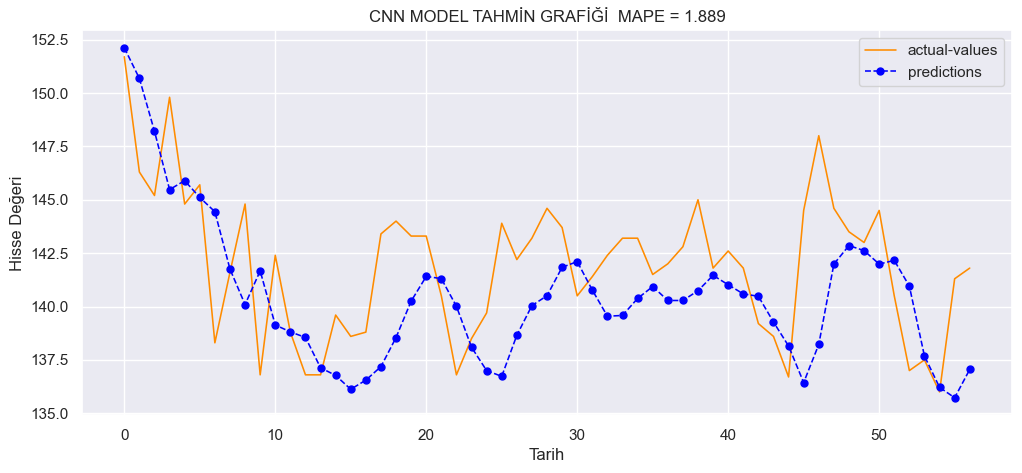

In [102]:
import matplotlib.pyplot as plt
plt.plot(y_test_inverse,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(kchol_cnn_y_pred,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("CNN MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(kchol_cnn_mape,3)))
plt.legend();

### KOMBİNASYON YÖNTEMİ VE BAŞARISI

# YÖNTEMLERİN MAPE DEĞERLERİ:

In [103]:
best_model = pd.DataFrame([kchol_ses_mape, kchol_des_mape, kchol_tes_mape,
                           kchol_arima_mape, kchol_sarima_mape,
                           kchol_ann_mape, kchol_cnn_mape],

                          index=["SES MODEL", "DES MODEL", "TES MODEL", "ARIMA MODEL", "SARIMA MODEL","ANN MODEL","CNN MODEL"],

                          columns=["MAPE Değerleri"])
print(best_model.sort_values("MAPE Değerleri", ascending=True));

              MAPE Değerleri
CNN MODEL           1.889464
ANN MODEL           1.898517
SES MODEL           1.953872
ARIMA MODEL         2.047730
SARIMA MODEL        2.051536
TES MODEL           2.752110
DES MODEL           6.492775


**EN DÜŞÜK MAPE DEĞERİNE SAHİP 3 YÖNTEMİN ORTALAMASINI ALALIM**

In [104]:
predictions = np.stack([kchol_cnn_y_pred.flatten(), kchol_ann_model_predictions.flatten(), kchol_ses_model_predictions.flatten()], axis=1)

# Bu tahminlerin ortalaması:
average_predictions = np.mean(predictions, axis=1)

print(average_predictions)

[141.8265363  148.57021315 148.20306285 146.71746257 147.74509755
 146.30077089 145.88218089 142.3920669  141.60445326 142.83252437
 139.90301454 140.62879397 139.58563    138.17308979 137.44273714
 137.82087552 137.92887769 138.27885176 140.16853457 141.65013189
 142.37875835 142.43011099 141.18524092 138.99215961 138.33822739
 138.45036368 140.56257557 141.30530434 141.94898368 142.9484777
 143.09542924 141.66365128 141.02766415 141.23112103 141.90985119
 142.31943746 141.66715325 141.58967728 141.91647505 142.96429549
 142.22606988 142.08022402 141.69630602 140.37443076 139.2880533
 137.73237836 140.29266544 143.61475464 144.05178716 143.63814684
 143.00812686 143.35256839 141.84855587 139.16301467 137.92966312
 136.91860849 138.56392911]


**KOMBİNE EDİLEN TAHMİNLERİN MAPE DEĞERİ**

In [105]:
from sklearn.metrics import mean_absolute_percentage_error
combined_mape = mean_absolute_percentage_error(test,average_predictions)*100
print(combined_mape) #  MAPE = 1.754662703230198

1.754662703230198


In [117]:
best_model = pd.DataFrame([kchol_cnn_mape, kchol_ann_mape,
                        kchol_ses_mape,combined_mape],

                          index=["CNN MODEL", "ANN MODEL","SES MODEL","COMBINED PREDICTION"],

                          columns=["KCHOL MAPE Değerleri"])
print(best_model.sort_values("KCHOL MAPE Değerleri", ascending=True));

                     KCHOL MAPE Değerleri
COMBINED PREDICTION              1.754663
CNN MODEL                        1.889464
ANN MODEL                        1.898517
SES MODEL                        1.953872


**YÖNTEMLERİN MAPE DEĞERLERİ BİRBİRİNE ÇOK YAKIN GELMİŞTİR. KOMBİNASYON İLE ELDE EDİLEN TAHMİNLERİN MAPE DEĞERİ 1. SIRADA YER ALMIŞTIR!**

In [109]:
combined_RMSE = np.sqrt(mean_squared_error(test,average_predictions)) # RMSE = 3.22762791748787
print(combined_RMSE);

3.22762791748787


In [115]:
best_model_RMSE = pd.DataFrame([kchol_cnn_rmse, kchol_ann_rmse,
                           kchol_ses_rmse, combined_RMSE],

                          index=["CNN MODEL", "ANN MODEL","SES MODEL","COMBINED PREDICTION"],

                          columns=["KCHOL RMSE Değerleri"])
print(best_model_RMSE.sort_values("KCHOL RMSE Değerleri", ascending=True));

                     KCHOL RMSE Değerleri
COMBINED PREDICTION              3.227628
ANN MODEL                        3.425057
CNN MODEL                        3.438072
SES MODEL                        5.363892


# KOMBİNE TAHMİNLERİN GRAFİĞİ:

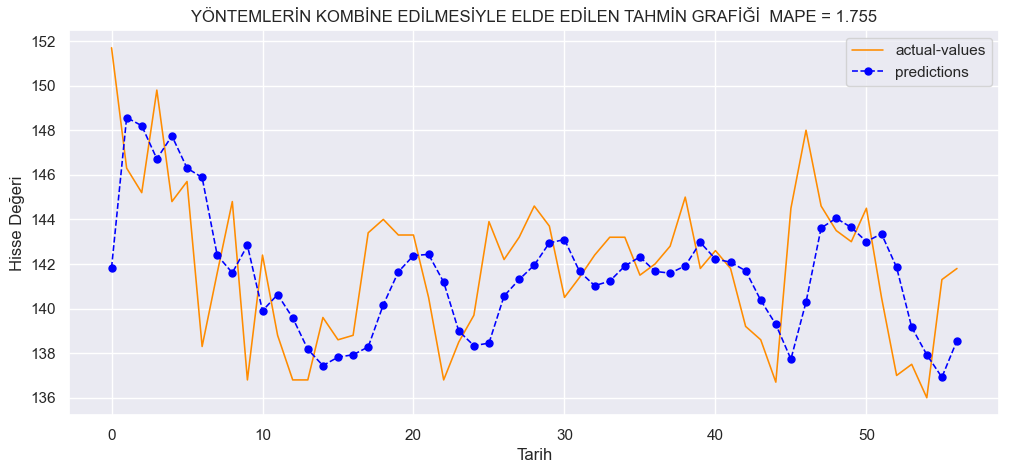

In [116]:
import matplotlib.pyplot as plt
plt.plot(y_test_inverse,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(average_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("YÖNTEMLERİN KOMBİNE EDİLMESİYLE ELDE EDİLEN TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(combined_mape,3)))
plt.legend();